# 前期准备

In [3]:
#加载常用库
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import cv2
import paddle
import paddleseg

In [9]:
### 划分数据集
random.seed(1000)
path_origin = '/home/aistudio/work/MosMedSegPNG/origin'
files = list(filter(lambda x: x.endswith('.png'), os.listdir(path_origin)))
random.shuffle(files)
rate = int(len(files) * 0.8)#训练集和测试集8：2
train_txt = open('/home/aistudio/work/MosMedSegPNG/train_list.txt','w')
val_txt = open('/home/aistudio/work/MosMedSegPNG/val_list.txt','w')
for i,f in enumerate(files):
    image_path = os.path.join(path_origin, f)
    label_path = image_path.replace("origin", "mask")
    if i < rate:
        train_txt.write(image_path + ' ' + label_path+ '\n')
    else:
        val_txt.write(image_path + ' ' + label_path+ '\n')
train_txt.close()
val_txt.close()

print('完成')

完成


# 搭建transforms</br>
进行数据增强，水平翻转，随机旋转，对比度、明度、随机模糊，随机裁剪等。

In [4]:
import paddleseg.transforms as T
from paddleseg.datasets import Dataset

train_transforms = [
    T.Resize(target_size=(550, 550)),
    T.RandomHorizontalFlip(),
    T.RandomDistort(brightness_range = 0.2,
                 contrast_range = 0.2,
                 saturation_range = 0.2,
                 hue_prob = 0),
    T.RandomRotation(max_rotation = 10,im_padding_value =(0,0,0),label_padding_value = 0),#随机旋转
    T.RandomBlur(),
    T.RandomPaddingCrop(crop_size = (512, 512),
                 im_padding_value = (0,0,0),
                 label_padding_value = 0),
    T.Normalize()
]
val_transforms = [
    T.Resize(target_size=(512, 512)),
    T.Normalize()
]

dataset_root = '/home/aistudio/work/MosMedSegPNG'
train_path  = '/home/aistudio/work/MosMedSegPNG/train_list.txt'
val_path  = '/home/aistudio/work/MosMedSegPNG/val_list.txt'
# 构建训练集
train_dataset = Dataset(
    transforms = train_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  train_path  = train_path,
                  mode = 'train'
                  )
#验证集
val_dataset = Dataset(
    transforms = val_transforms,
                  dataset_root = dataset_root,
                  num_classes = 2,
                  val_path = val_path,
                  mode = 'val'
                  )



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

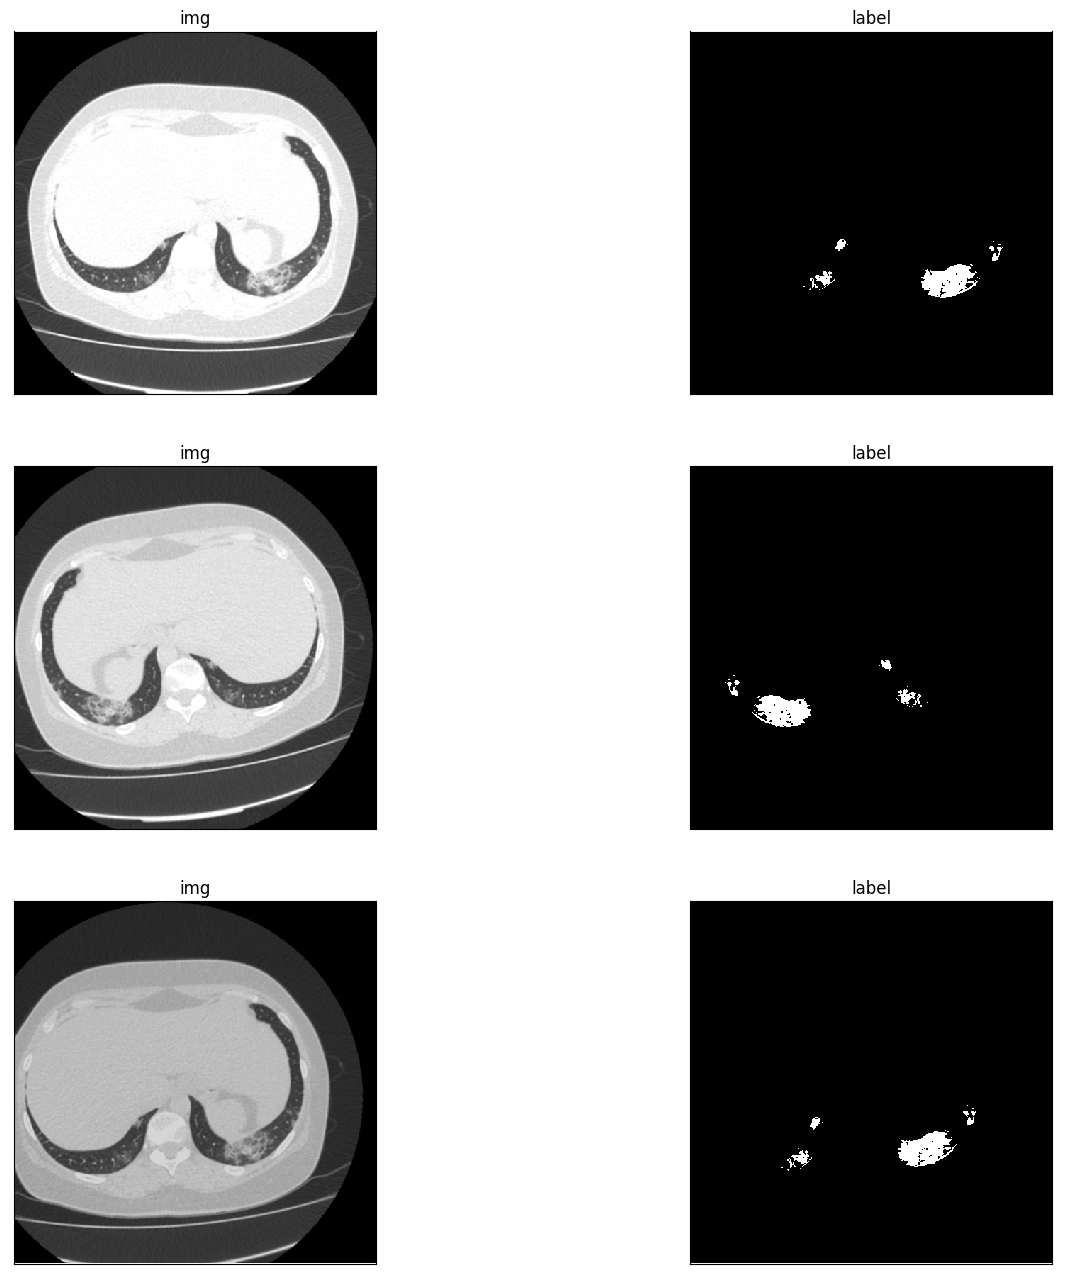

In [6]:
#预览经过数据增强后的数据。
plt.figure(figsize=(16,16))
for i in range(1,6,2):
    img, label = train_dataset[50]
    img = np.transpose(img, (1,2,0))
    img = img*0.5 + 0.5
    plt.subplot(3,2,i),plt.imshow(img,'gray'),plt.title('img'),plt.xticks([]),plt.yticks([])
    plt.subplot(3,2,i+1),plt.imshow(label,'gray'),plt.title('label'),plt.xticks([]),plt.yticks([])
    plt.show

# 模型训练

In [7]:
from paddleseg.models import UNet, BiSeNetV2
from paddleseg.core import train
from paddleseg.models.losses import CrossEntropyLoss,DiceLoss, MixedLoss
import paddle

num_classes = 2

In [9]:
# 训练BiSeNetV2
model = BiSeNetV2(num_classes=num_classes)

# 设置学习率  
batch_size=32
log_iters = int(len(train_dataset)/batch_size /3) #日志打印间隔
iters = int(len(train_dataset)/batch_size) * 200 #训练次数
save_interval = int(len(train_dataset)/batch_size) * 5 #保存的间隔次数
base_lr = 0.02
#优化器和损失函数
lr = paddle.optimizer.lr.PolynomialDecay(base_lr, power=0.9, decay_steps=iters, end_lr=0.0000125)
optimizer = paddle.optimizer.Momentum(lr, parameters=model.parameters(), momentum=0.9, weight_decay=4.0e-5)
mixtureLosses = [CrossEntropyLoss(),DiceLoss() ]
mixtureCoef = [0.7,0.3]
losses = {}
losses['types'] = [MixedLoss(mixtureLosses, mixtureCoef)]*5
losses['coef'] = [1]*5

train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='/home/aistudio/Bisnet',
    iters=iters,
    batch_size=batch_size,
    save_interval=save_interval,
    log_iters=log_iters,
    losses=losses,#传入 loss函数
    use_vdl=True)

2022-10-29 08:08:02 [INFO]	[TRAIN] epoch: 1, iter: 6/3800, loss: 2.2685, lr: 0.019976, batch_cost: 1.4460, reader_cost: 0.87317, ips: 22.1308 samples/sec | ETA 01:31:25
2022-10-29 08:08:10 [INFO]	[TRAIN] epoch: 1, iter: 12/3800, loss: 1.1265, lr: 0.019948, batch_cost: 1.3435, reader_cost: 0.77078, ips: 23.8179 samples/sec | ETA 01:24:49
2022-10-29 08:08:18 [INFO]	[TRAIN] epoch: 1, iter: 18/3800, loss: 0.9405, lr: 0.019920, batch_cost: 1.3006, reader_cost: 0.72692, ips: 24.6033 samples/sec | ETA 01:21:59
2022-10-29 08:08:26 [INFO]	[TRAIN] epoch: 2, iter: 24/3800, loss: 0.8938, lr: 0.019891, batch_cost: 1.3813, reader_cost: 0.80813, ips: 23.1658 samples/sec | ETA 01:26:55
2022-10-29 08:08:34 [INFO]	[TRAIN] epoch: 2, iter: 30/3800, loss: 0.8933, lr: 0.019863, batch_cost: 1.3143, reader_cost: 0.74027, ips: 24.3470 samples/sec | ETA 01:22:35
2022-10-29 08:08:42 [INFO]	[TRAIN] epoch: 2, iter: 36/3800, loss: 0.8665, lr: 0.019834, batch_cost: 1.2603, reader_cost: 0.68781, ips: 25.3902 samples/

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0253 - reader cost: 2.2194e-04


2022-10-29 08:10:02 [INFO]	[EVAL] #Images: 157 mIoU: 0.6553 Acc: 0.9937 Kappa: 0.9937 
2022-10-29 08:10:02 [INFO]	[EVAL] Class IoU: 
[0.9937 0.3169]
2022-10-29 08:10:02 [INFO]	[EVAL] Class Acc: 
[0.998  0.4022]
2022-10-29 08:10:02 [INFO]	[EVAL] The model with the best validation mIoU (0.6553) was saved at iter 95.
2022-10-29 08:10:04 [INFO]	[TRAIN] epoch: 6, iter: 96/3800, loss: 0.7375, lr: 0.019550, batch_cost: 1.3462, reader_cost: 0.76874, ips: 23.7706 samples/sec | ETA 01:23:06
2022-10-29 08:10:12 [INFO]	[TRAIN] epoch: 6, iter: 102/3800, loss: 0.7324, lr: 0.019521, batch_cost: 1.2362, reader_cost: 0.66232, ips: 25.8861 samples/sec | ETA 01:16:11
2022-10-29 08:10:19 [INFO]	[TRAIN] epoch: 6, iter: 108/3800, loss: 0.7186, lr: 0.019493, batch_cost: 1.2777, reader_cost: 0.70535, ips: 25.0455 samples/sec | ETA 01:18:37
2022-10-29 08:10:27 [INFO]	[TRAIN] epoch: 6, iter: 114/3800, loss: 0.7169, lr: 0.019464, batch_cost: 1.2747, reader_cost: 0.70220, ips: 25.1033 samples/sec | ETA 01:18:18
2

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.1410e-04


2022-10-29 08:12:08 [INFO]	[EVAL] #Images: 157 mIoU: 0.6903 Acc: 0.9966 Kappa: 0.9966 
2022-10-29 08:12:08 [INFO]	[EVAL] Class IoU: 
[0.9966 0.384 ]
2022-10-29 08:12:08 [INFO]	[EVAL] Class Acc: 
[0.9972 0.788 ]
2022-10-29 08:12:08 [INFO]	[EVAL] The model with the best validation mIoU (0.6903) was saved at iter 190.
2022-10-29 08:12:11 [INFO]	[TRAIN] epoch: 11, iter: 192/3800, loss: 0.5923, lr: 0.019094, batch_cost: 1.2902, reader_cost: 0.71428, ips: 24.8018 samples/sec | ETA 01:17:35
2022-10-29 08:12:19 [INFO]	[TRAIN] epoch: 11, iter: 198/3800, loss: 0.5576, lr: 0.019065, batch_cost: 1.2840, reader_cost: 0.71202, ips: 24.9212 samples/sec | ETA 01:17:05
2022-10-29 08:12:26 [INFO]	[TRAIN] epoch: 11, iter: 204/3800, loss: 0.5555, lr: 0.019036, batch_cost: 1.2323, reader_cost: 0.66043, ips: 25.9667 samples/sec | ETA 01:13:51
2022-10-29 08:12:34 [INFO]	[TRAIN] epoch: 12, iter: 210/3800, loss: 0.5182, lr: 0.019008, batch_cost: 1.3042, reader_cost: 0.73208, ips: 24.5356 samples/sec | ETA 01:1

157/157 [==============================] - 4s 28ms/step - batch_cost: 0.0279 - reader cost: 2.7284e-04


2022-10-29 08:14:14 [INFO]	[EVAL] #Images: 157 mIoU: 0.7316 Acc: 0.9968 Kappa: 0.9968 
2022-10-29 08:14:14 [INFO]	[EVAL] Class IoU: 
[0.9967 0.4664]
2022-10-29 08:14:14 [INFO]	[EVAL] Class Acc: 
[0.9979 0.7043]
2022-10-29 08:14:15 [INFO]	[EVAL] The model with the best validation mIoU (0.7316) was saved at iter 285.
2022-10-29 08:14:19 [INFO]	[TRAIN] epoch: 16, iter: 288/3800, loss: 0.5038, lr: 0.018636, batch_cost: 1.3015, reader_cost: 0.72252, ips: 24.5879 samples/sec | ETA 01:16:10
2022-10-29 08:14:26 [INFO]	[TRAIN] epoch: 16, iter: 294/3800, loss: 0.5002, lr: 0.018607, batch_cost: 1.2631, reader_cost: 0.69045, ips: 25.3353 samples/sec | ETA 01:13:48
2022-10-29 08:14:34 [INFO]	[TRAIN] epoch: 16, iter: 300/3800, loss: 0.5081, lr: 0.018579, batch_cost: 1.2662, reader_cost: 0.69261, ips: 25.2721 samples/sec | ETA 01:13:51
2022-10-29 08:14:42 [INFO]	[TRAIN] epoch: 17, iter: 306/3800, loss: 0.4886, lr: 0.018550, batch_cost: 1.3329, reader_cost: 0.75889, ips: 24.0072 samples/sec | ETA 01:1

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0251 - reader cost: 2.5284e-04


2022-10-29 08:16:21 [INFO]	[EVAL] #Images: 157 mIoU: 0.7400 Acc: 0.9965 Kappa: 0.9965 
2022-10-29 08:16:21 [INFO]	[EVAL] Class IoU: 
[0.9965 0.4836]
2022-10-29 08:16:21 [INFO]	[EVAL] Class Acc: 
[0.9984 0.6305]
2022-10-29 08:16:21 [INFO]	[EVAL] The model with the best validation mIoU (0.7400) was saved at iter 380.
2022-10-29 08:16:26 [INFO]	[TRAIN] epoch: 21, iter: 384/3800, loss: 0.4769, lr: 0.018177, batch_cost: 1.3249, reader_cost: 0.74815, ips: 24.1525 samples/sec | ETA 01:15:25
2022-10-29 08:16:34 [INFO]	[TRAIN] epoch: 21, iter: 390/3800, loss: 0.4746, lr: 0.018149, batch_cost: 1.2525, reader_cost: 0.67953, ips: 25.5483 samples/sec | ETA 01:11:11
2022-10-29 08:16:42 [INFO]	[TRAIN] epoch: 21, iter: 396/3800, loss: 0.4561, lr: 0.018120, batch_cost: 1.2956, reader_cost: 0.72342, ips: 24.6993 samples/sec | ETA 01:13:30
2022-10-29 08:16:50 [INFO]	[TRAIN] epoch: 22, iter: 402/3800, loss: 0.4590, lr: 0.018091, batch_cost: 1.3720, reader_cost: 0.79801, ips: 23.3242 samples/sec | ETA 01:1

157/157 [==============================] - 4s 28ms/step - batch_cost: 0.0274 - reader cost: 2.4376e-04


2022-10-29 08:18:27 [INFO]	[EVAL] #Images: 157 mIoU: 0.7524 Acc: 0.9969 Kappa: 0.9969 
2022-10-29 08:18:27 [INFO]	[EVAL] Class IoU: 
[0.9969 0.5079]
2022-10-29 08:18:27 [INFO]	[EVAL] Class Acc: 
[0.9983 0.6963]
2022-10-29 08:18:27 [INFO]	[EVAL] The model with the best validation mIoU (0.7524) was saved at iter 475.
2022-10-29 08:18:34 [INFO]	[TRAIN] epoch: 26, iter: 480/3800, loss: 0.4427, lr: 0.017717, batch_cost: 1.3369, reader_cost: 0.75988, ips: 23.9362 samples/sec | ETA 01:13:58
2022-10-29 08:18:41 [INFO]	[TRAIN] epoch: 26, iter: 486/3800, loss: 0.4198, lr: 0.017689, batch_cost: 1.2554, reader_cost: 0.68286, ips: 25.4898 samples/sec | ETA 01:09:20
2022-10-29 08:18:49 [INFO]	[TRAIN] epoch: 26, iter: 492/3800, loss: 0.4696, lr: 0.017660, batch_cost: 1.2919, reader_cost: 0.71753, ips: 24.7702 samples/sec | ETA 01:11:13
2022-10-29 08:18:57 [INFO]	[TRAIN] epoch: 27, iter: 498/3800, loss: 0.4575, lr: 0.017631, batch_cost: 1.3805, reader_cost: 0.80627, ips: 23.1802 samples/sec | ETA 01:1

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0250 - reader cost: 2.2191e-04


2022-10-29 08:20:33 [INFO]	[EVAL] #Images: 157 mIoU: 0.7375 Acc: 0.9962 Kappa: 0.9962 
2022-10-29 08:20:33 [INFO]	[EVAL] Class IoU: 
[0.9962 0.4788]
2022-10-29 08:20:33 [INFO]	[EVAL] Class Acc: 
[0.9985 0.5996]
2022-10-29 08:20:33 [INFO]	[EVAL] The model with the best validation mIoU (0.7524) was saved at iter 475.
2022-10-29 08:20:41 [INFO]	[TRAIN] epoch: 31, iter: 576/3800, loss: 0.4516, lr: 0.017256, batch_cost: 1.3328, reader_cost: 0.75497, ips: 24.0105 samples/sec | ETA 01:11:36
2022-10-29 08:20:49 [INFO]	[TRAIN] epoch: 31, iter: 582/3800, loss: 0.4588, lr: 0.017227, batch_cost: 1.2656, reader_cost: 0.69288, ips: 25.2843 samples/sec | ETA 01:07:52
2022-10-29 08:20:56 [INFO]	[TRAIN] epoch: 31, iter: 588/3800, loss: 0.4275, lr: 0.017198, batch_cost: 1.2448, reader_cost: 0.67147, ips: 25.7075 samples/sec | ETA 01:06:38
2022-10-29 08:21:04 [INFO]	[TRAIN] epoch: 32, iter: 594/3800, loss: 0.4379, lr: 0.017170, batch_cost: 1.3284, reader_cost: 0.75595, ips: 24.0890 samples/sec | ETA 01:1

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0258 - reader cost: 2.2028e-04


2022-10-29 08:22:39 [INFO]	[EVAL] #Images: 157 mIoU: 0.7499 Acc: 0.9964 Kappa: 0.9964 
2022-10-29 08:22:39 [INFO]	[EVAL] Class IoU: 
[0.9964 0.5035]
2022-10-29 08:22:39 [INFO]	[EVAL] Class Acc: 
[0.9988 0.6032]
2022-10-29 08:22:39 [INFO]	[EVAL] The model with the best validation mIoU (0.7524) was saved at iter 475.
2022-10-29 08:22:40 [INFO]	[TRAIN] epoch: 36, iter: 666/3800, loss: 0.4148, lr: 0.016822, batch_cost: 1.3209, reader_cost: 0.74188, ips: 24.2259 samples/sec | ETA 01:08:59
2022-10-29 08:22:48 [INFO]	[TRAIN] epoch: 36, iter: 672/3800, loss: 0.4257, lr: 0.016794, batch_cost: 1.2526, reader_cost: 0.68095, ips: 25.5475 samples/sec | ETA 01:05:18
2022-10-29 08:22:56 [INFO]	[TRAIN] epoch: 36, iter: 678/3800, loss: 0.4382, lr: 0.016765, batch_cost: 1.2797, reader_cost: 0.70765, ips: 25.0063 samples/sec | ETA 01:06:35
2022-10-29 08:23:03 [INFO]	[TRAIN] epoch: 36, iter: 684/3800, loss: 0.4348, lr: 0.016736, batch_cost: 1.2612, reader_cost: 0.68713, ips: 25.3722 samples/sec | ETA 01:0

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0247 - reader cost: 2.1369e-04


2022-10-29 08:24:45 [INFO]	[EVAL] #Images: 157 mIoU: 0.6768 Acc: 0.9967 Kappa: 0.9967 
2022-10-29 08:24:45 [INFO]	[EVAL] Class IoU: 
[0.9967 0.357 ]
2022-10-29 08:24:45 [INFO]	[EVAL] Class Acc: 
[0.9969 0.8719]
2022-10-29 08:24:45 [INFO]	[EVAL] The model with the best validation mIoU (0.7524) was saved at iter 475.
2022-10-29 08:24:48 [INFO]	[TRAIN] epoch: 41, iter: 762/3800, loss: 0.4081, lr: 0.016358, batch_cost: 1.3260, reader_cost: 0.74910, ips: 24.1325 samples/sec | ETA 01:07:08
2022-10-29 08:24:56 [INFO]	[TRAIN] epoch: 41, iter: 768/3800, loss: 0.4299, lr: 0.016329, batch_cost: 1.3107, reader_cost: 0.73824, ips: 24.4143 samples/sec | ETA 01:06:14
2022-10-29 08:25:04 [INFO]	[TRAIN] epoch: 41, iter: 774/3800, loss: 0.4075, lr: 0.016300, batch_cost: 1.2756, reader_cost: 0.70156, ips: 25.0861 samples/sec | ETA 01:04:19
2022-10-29 08:25:12 [INFO]	[TRAIN] epoch: 42, iter: 780/3800, loss: 0.4206, lr: 0.016271, batch_cost: 1.3020, reader_cost: 0.72766, ips: 24.5781 samples/sec | ETA 01:0

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0253 - reader cost: 2.5610e-04


2022-10-29 08:26:52 [INFO]	[EVAL] #Images: 157 mIoU: 0.7526 Acc: 0.9972 Kappa: 0.9972 
2022-10-29 08:26:52 [INFO]	[EVAL] Class IoU: 
[0.9972 0.508 ]
2022-10-29 08:26:52 [INFO]	[EVAL] Class Acc: 
[0.998  0.7844]
2022-10-29 08:26:52 [INFO]	[EVAL] The model with the best validation mIoU (0.7526) was saved at iter 855.
2022-10-29 08:26:56 [INFO]	[TRAIN] epoch: 46, iter: 858/3800, loss: 0.4199, lr: 0.015893, batch_cost: 1.3281, reader_cost: 0.75185, ips: 24.0947 samples/sec | ETA 01:05:07
2022-10-29 08:27:04 [INFO]	[TRAIN] epoch: 46, iter: 864/3800, loss: 0.4126, lr: 0.015864, batch_cost: 1.3035, reader_cost: 0.73082, ips: 24.5495 samples/sec | ETA 01:03:47
2022-10-29 08:27:12 [INFO]	[TRAIN] epoch: 46, iter: 870/3800, loss: 0.4211, lr: 0.015835, batch_cost: 1.2455, reader_cost: 0.67306, ips: 25.6915 samples/sec | ETA 01:00:49
2022-10-29 08:27:19 [INFO]	[TRAIN] epoch: 47, iter: 876/3800, loss: 0.4225, lr: 0.015806, batch_cost: 1.3206, reader_cost: 0.74726, ips: 24.2305 samples/sec | ETA 01:0

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0251 - reader cost: 2.4165e-04


2022-10-29 08:28:58 [INFO]	[EVAL] #Images: 157 mIoU: 0.7644 Acc: 0.9972 Kappa: 0.9972 
2022-10-29 08:28:58 [INFO]	[EVAL] Class IoU: 
[0.9972 0.5316]
2022-10-29 08:28:58 [INFO]	[EVAL] Class Acc: 
[0.9983 0.7504]
2022-10-29 08:28:58 [INFO]	[EVAL] The model with the best validation mIoU (0.7644) was saved at iter 950.
2022-10-29 08:29:04 [INFO]	[TRAIN] epoch: 51, iter: 954/3800, loss: 0.4183, lr: 0.015426, batch_cost: 1.3611, reader_cost: 0.78550, ips: 23.5098 samples/sec | ETA 01:04:33
2022-10-29 08:29:11 [INFO]	[TRAIN] epoch: 51, iter: 960/3800, loss: 0.3909, lr: 0.015397, batch_cost: 1.2550, reader_cost: 0.68178, ips: 25.4978 samples/sec | ETA 00:59:24
2022-10-29 08:29:19 [INFO]	[TRAIN] epoch: 51, iter: 966/3800, loss: 0.4391, lr: 0.015368, batch_cost: 1.2388, reader_cost: 0.66669, ips: 25.8313 samples/sec | ETA 00:58:30
2022-10-29 08:29:27 [INFO]	[TRAIN] epoch: 52, iter: 972/3800, loss: 0.4003, lr: 0.015338, batch_cost: 1.3463, reader_cost: 0.77306, ips: 23.7692 samples/sec | ETA 01:0

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0247 - reader cost: 2.3318e-04


2022-10-29 08:31:06 [INFO]	[EVAL] #Images: 157 mIoU: 0.7406 Acc: 0.9972 Kappa: 0.9972 
2022-10-29 08:31:06 [INFO]	[EVAL] Class IoU: 
[0.9972 0.484 ]
2022-10-29 08:31:06 [INFO]	[EVAL] Class Acc: 
[0.9978 0.817 ]
2022-10-29 08:31:06 [INFO]	[EVAL] The model with the best validation mIoU (0.7644) was saved at iter 950.
2022-10-29 08:31:12 [INFO]	[TRAIN] epoch: 56, iter: 1050/3800, loss: 0.3783, lr: 0.014957, batch_cost: 1.3507, reader_cost: 0.77323, ips: 23.6910 samples/sec | ETA 01:01:54
2022-10-29 08:31:20 [INFO]	[TRAIN] epoch: 56, iter: 1056/3800, loss: 0.4139, lr: 0.014928, batch_cost: 1.2623, reader_cost: 0.68760, ips: 25.3507 samples/sec | ETA 00:57:43
2022-10-29 08:31:28 [INFO]	[TRAIN] epoch: 56, iter: 1062/3800, loss: 0.4210, lr: 0.014899, batch_cost: 1.2608, reader_cost: 0.68759, ips: 25.3810 samples/sec | ETA 00:57:32
2022-10-29 08:31:36 [INFO]	[TRAIN] epoch: 57, iter: 1068/3800, loss: 0.4163, lr: 0.014869, batch_cost: 1.3332, reader_cost: 0.76002, ips: 24.0020 samples/sec | ETA 

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.5423e-04


2022-10-29 08:33:12 [INFO]	[EVAL] #Images: 157 mIoU: 0.7706 Acc: 0.9971 Kappa: 0.9971 
2022-10-29 08:33:12 [INFO]	[EVAL] Class IoU: 
[0.9971 0.5441]
2022-10-29 08:33:12 [INFO]	[EVAL] Class Acc: 
[0.9985 0.7082]
2022-10-29 08:33:12 [INFO]	[EVAL] The model with the best validation mIoU (0.7706) was saved at iter 1140.
2022-10-29 08:33:20 [INFO]	[TRAIN] epoch: 61, iter: 1146/3800, loss: 0.4081, lr: 0.014487, batch_cost: 1.3318, reader_cost: 0.75483, ips: 24.0272 samples/sec | ETA 00:58:54
2022-10-29 08:33:28 [INFO]	[TRAIN] epoch: 61, iter: 1152/3800, loss: 0.3642, lr: 0.014458, batch_cost: 1.2343, reader_cost: 0.66173, ips: 25.9253 samples/sec | ETA 00:54:28
2022-10-29 08:33:35 [INFO]	[TRAIN] epoch: 61, iter: 1158/3800, loss: 0.4050, lr: 0.014428, batch_cost: 1.2707, reader_cost: 0.69695, ips: 25.1820 samples/sec | ETA 00:55:57
2022-10-29 08:33:43 [INFO]	[TRAIN] epoch: 62, iter: 1164/3800, loss: 0.4141, lr: 0.014399, batch_cost: 1.3511, reader_cost: 0.77587, ips: 23.6837 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0246 - reader cost: 2.2190e-04


2022-10-29 08:35:20 [INFO]	[EVAL] #Images: 157 mIoU: 0.7616 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:35:20 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5259]
2022-10-29 08:35:20 [INFO]	[EVAL] Class Acc: 
[0.998  0.8049]
2022-10-29 08:35:20 [INFO]	[EVAL] The model with the best validation mIoU (0.7706) was saved at iter 1140.
2022-10-29 08:35:21 [INFO]	[TRAIN] epoch: 66, iter: 1236/3800, loss: 0.4064, lr: 0.014045, batch_cost: 1.3298, reader_cost: 0.75377, ips: 24.0637 samples/sec | ETA 00:56:49
2022-10-29 08:35:29 [INFO]	[TRAIN] epoch: 66, iter: 1242/3800, loss: 0.3978, lr: 0.014015, batch_cost: 1.2595, reader_cost: 0.68541, ips: 25.4075 samples/sec | ETA 00:53:41
2022-10-29 08:35:37 [INFO]	[TRAIN] epoch: 66, iter: 1248/3800, loss: 0.3717, lr: 0.013986, batch_cost: 1.2608, reader_cost: 0.68796, ips: 25.3807 samples/sec | ETA 00:53:37
2022-10-29 08:35:44 [INFO]	[TRAIN] epoch: 66, iter: 1254/3800, loss: 0.4043, lr: 0.013956, batch_cost: 1.2864, reader_cost: 0.71312, ips: 24.8756 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0248 - reader cost: 2.2426e-04


2022-10-29 08:37:27 [INFO]	[EVAL] #Images: 157 mIoU: 0.7706 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:37:27 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5439]
2022-10-29 08:37:27 [INFO]	[EVAL] Class Acc: 
[0.9984 0.747 ]
2022-10-29 08:37:27 [INFO]	[EVAL] The model with the best validation mIoU (0.7706) was saved at iter 1140.
2022-10-29 08:37:30 [INFO]	[TRAIN] epoch: 71, iter: 1332/3800, loss: 0.4166, lr: 0.013571, batch_cost: 1.3237, reader_cost: 0.74480, ips: 24.1755 samples/sec | ETA 00:54:26
2022-10-29 08:37:38 [INFO]	[TRAIN] epoch: 71, iter: 1338/3800, loss: 0.3952, lr: 0.013542, batch_cost: 1.2721, reader_cost: 0.69801, ips: 25.1544 samples/sec | ETA 00:52:12
2022-10-29 08:37:45 [INFO]	[TRAIN] epoch: 71, iter: 1344/3800, loss: 0.3802, lr: 0.013512, batch_cost: 1.2598, reader_cost: 0.68635, ips: 25.4007 samples/sec | ETA 00:51:34
2022-10-29 08:37:53 [INFO]	[TRAIN] epoch: 72, iter: 1350/3800, loss: 0.3886, lr: 0.013482, batch_cost: 1.3267, reader_cost: 0.75313, ips: 24.1202 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0250 - reader cost: 2.1918e-04


2022-10-29 08:39:35 [INFO]	[EVAL] #Images: 157 mIoU: 0.7736 Acc: 0.9972 Kappa: 0.9972 
2022-10-29 08:39:35 [INFO]	[EVAL] Class IoU: 
[0.9972 0.55  ]
2022-10-29 08:39:35 [INFO]	[EVAL] Class Acc: 
[0.9985 0.7226]
2022-10-29 08:39:35 [INFO]	[EVAL] The model with the best validation mIoU (0.7736) was saved at iter 1425.
2022-10-29 08:39:39 [INFO]	[TRAIN] epoch: 76, iter: 1428/3800, loss: 0.3884, lr: 0.013096, batch_cost: 1.2894, reader_cost: 0.71396, ips: 24.8168 samples/sec | ETA 00:50:58
2022-10-29 08:39:47 [INFO]	[TRAIN] epoch: 76, iter: 1434/3800, loss: 0.3592, lr: 0.013066, batch_cost: 1.2842, reader_cost: 0.71172, ips: 24.9183 samples/sec | ETA 00:50:38
2022-10-29 08:39:54 [INFO]	[TRAIN] epoch: 76, iter: 1440/3800, loss: 0.3981, lr: 0.013036, batch_cost: 1.2643, reader_cost: 0.69166, ips: 25.3106 samples/sec | ETA 00:49:43
2022-10-29 08:40:02 [INFO]	[TRAIN] epoch: 77, iter: 1446/3800, loss: 0.4062, lr: 0.013007, batch_cost: 1.3473, reader_cost: 0.77496, ips: 23.7510 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.4176e-04


2022-10-29 08:41:42 [INFO]	[EVAL] #Images: 157 mIoU: 0.7716 Acc: 0.9970 Kappa: 0.9970 
2022-10-29 08:41:42 [INFO]	[EVAL] Class IoU: 
[0.997  0.5461]
2022-10-29 08:41:42 [INFO]	[EVAL] Class Acc: 
[0.9987 0.6876]
2022-10-29 08:41:42 [INFO]	[EVAL] The model with the best validation mIoU (0.7736) was saved at iter 1425.
2022-10-29 08:41:48 [INFO]	[TRAIN] epoch: 81, iter: 1524/3800, loss: 0.3692, lr: 0.012619, batch_cost: 1.3139, reader_cost: 0.73712, ips: 24.3549 samples/sec | ETA 00:49:50
2022-10-29 08:41:55 [INFO]	[TRAIN] epoch: 81, iter: 1530/3800, loss: 0.3891, lr: 0.012589, batch_cost: 1.2789, reader_cost: 0.70608, ips: 25.0217 samples/sec | ETA 00:48:23
2022-10-29 08:42:03 [INFO]	[TRAIN] epoch: 81, iter: 1536/3800, loss: 0.3788, lr: 0.012559, batch_cost: 1.2689, reader_cost: 0.69620, ips: 25.2196 samples/sec | ETA 00:47:52
2022-10-29 08:42:11 [INFO]	[TRAIN] epoch: 82, iter: 1542/3800, loss: 0.3915, lr: 0.012529, batch_cost: 1.3260, reader_cost: 0.75188, ips: 24.1323 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0250 - reader cost: 2.3637e-04


2022-10-29 08:43:50 [INFO]	[EVAL] #Images: 157 mIoU: 0.7665 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 08:43:50 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5356]
2022-10-29 08:43:50 [INFO]	[EVAL] Class Acc: 
[0.9981 0.7927]
2022-10-29 08:43:50 [INFO]	[EVAL] The model with the best validation mIoU (0.7736) was saved at iter 1425.
2022-10-29 08:43:56 [INFO]	[TRAIN] epoch: 86, iter: 1620/3800, loss: 0.3878, lr: 0.012139, batch_cost: 1.3268, reader_cost: 0.75155, ips: 24.1188 samples/sec | ETA 00:48:12
2022-10-29 08:44:04 [INFO]	[TRAIN] epoch: 86, iter: 1626/3800, loss: 0.3619, lr: 0.012109, batch_cost: 1.2583, reader_cost: 0.68455, ips: 25.4321 samples/sec | ETA 00:45:35
2022-10-29 08:44:11 [INFO]	[TRAIN] epoch: 86, iter: 1632/3800, loss: 0.3775, lr: 0.012079, batch_cost: 1.2776, reader_cost: 0.70341, ips: 25.0461 samples/sec | ETA 00:46:09
2022-10-29 08:44:20 [INFO]	[TRAIN] epoch: 87, iter: 1638/3800, loss: 0.3741, lr: 0.012049, batch_cost: 1.3650, reader_cost: 0.79197, ips: 23.4440 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0247 - reader cost: 2.1406e-04


2022-10-29 08:45:57 [INFO]	[EVAL] #Images: 157 mIoU: 0.7696 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:45:57 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5418]
2022-10-29 08:45:57 [INFO]	[EVAL] Class Acc: 
[0.9983 0.7704]
2022-10-29 08:45:57 [INFO]	[EVAL] The model with the best validation mIoU (0.7736) was saved at iter 1425.
2022-10-29 08:46:05 [INFO]	[TRAIN] epoch: 91, iter: 1716/3800, loss: 0.3828, lr: 0.011658, batch_cost: 1.3741, reader_cost: 0.79531, ips: 23.2871 samples/sec | ETA 00:47:43
2022-10-29 08:46:13 [INFO]	[TRAIN] epoch: 91, iter: 1722/3800, loss: 0.3503, lr: 0.011628, batch_cost: 1.3225, reader_cost: 0.74815, ips: 24.1968 samples/sec | ETA 00:45:48
2022-10-29 08:46:21 [INFO]	[TRAIN] epoch: 91, iter: 1728/3800, loss: 0.4016, lr: 0.011597, batch_cost: 1.3064, reader_cost: 0.73216, ips: 24.4950 samples/sec | ETA 00:45:06
2022-10-29 08:46:29 [INFO]	[TRAIN] epoch: 92, iter: 1734/3800, loss: 0.3881, lr: 0.011567, batch_cost: 1.3336, reader_cost: 0.76000, ips: 23.9952 samples/sec | ETA

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0258 - reader cost: 2.3705e-04


2022-10-29 08:48:05 [INFO]	[EVAL] #Images: 157 mIoU: 0.7520 Acc: 0.9971 Kappa: 0.9971 
2022-10-29 08:48:05 [INFO]	[EVAL] Class IoU: 
[0.9971 0.507 ]
2022-10-29 08:48:05 [INFO]	[EVAL] Class Acc: 
[0.9981 0.7418]
2022-10-29 08:48:05 [INFO]	[EVAL] The model with the best validation mIoU (0.7736) was saved at iter 1425.
2022-10-29 08:48:07 [INFO]	[TRAIN] epoch: 96, iter: 1806/3800, loss: 0.3770, lr: 0.011204, batch_cost: 1.3565, reader_cost: 0.77752, ips: 23.5907 samples/sec | ETA 00:45:04
2022-10-29 08:48:15 [INFO]	[TRAIN] epoch: 96, iter: 1812/3800, loss: 0.3930, lr: 0.011174, batch_cost: 1.2722, reader_cost: 0.69962, ips: 25.1534 samples/sec | ETA 00:42:09
2022-10-29 08:48:22 [INFO]	[TRAIN] epoch: 96, iter: 1818/3800, loss: 0.3755, lr: 0.011144, batch_cost: 1.2764, reader_cost: 0.70226, ips: 25.0712 samples/sec | ETA 00:42:09
2022-10-29 08:48:30 [INFO]	[TRAIN] epoch: 96, iter: 1824/3800, loss: 0.3725, lr: 0.011113, batch_cost: 1.2848, reader_cost: 0.71079, ips: 24.9058 samples/sec | ETA

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0247 - reader cost: 2.5043e-04


2022-10-29 08:50:13 [INFO]	[EVAL] #Images: 157 mIoU: 0.7802 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:50:13 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5632]
2022-10-29 08:50:13 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7221]
2022-10-29 08:50:13 [INFO]	[EVAL] The model with the best validation mIoU (0.7802) was saved at iter 1900.
2022-10-29 08:50:16 [INFO]	[TRAIN] epoch: 101, iter: 1902/3800, loss: 0.3720, lr: 0.010718, batch_cost: 1.3483, reader_cost: 0.76923, ips: 23.7327 samples/sec | ETA 00:42:39
2022-10-29 08:50:24 [INFO]	[TRAIN] epoch: 101, iter: 1908/3800, loss: 0.3864, lr: 0.010688, batch_cost: 1.2855, reader_cost: 0.71240, ips: 24.8930 samples/sec | ETA 00:40:32
2022-10-29 08:50:31 [INFO]	[TRAIN] epoch: 101, iter: 1914/3800, loss: 0.3558, lr: 0.010658, batch_cost: 1.2726, reader_cost: 0.70018, ips: 25.1460 samples/sec | ETA 00:40:00
2022-10-29 08:50:40 [INFO]	[TRAIN] epoch: 102, iter: 1920/3800, loss: 0.3675, lr: 0.010627, batch_cost: 1.3648, reader_cost: 0.79042, ips: 23.4467 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0250 - reader cost: 2.3046e-04


2022-10-29 08:52:22 [INFO]	[EVAL] #Images: 157 mIoU: 0.7757 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:52:22 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5541]
2022-10-29 08:52:22 [INFO]	[EVAL] Class Acc: 
[0.9984 0.7491]
2022-10-29 08:52:22 [INFO]	[EVAL] The model with the best validation mIoU (0.7802) was saved at iter 1900.
2022-10-29 08:52:26 [INFO]	[TRAIN] epoch: 106, iter: 1998/3800, loss: 0.3473, lr: 0.010230, batch_cost: 1.3755, reader_cost: 0.79767, ips: 23.2639 samples/sec | ETA 00:41:18
2022-10-29 08:52:34 [INFO]	[TRAIN] epoch: 106, iter: 2004/3800, loss: 0.3621, lr: 0.010200, batch_cost: 1.2853, reader_cost: 0.71355, ips: 24.8961 samples/sec | ETA 00:38:28
2022-10-29 08:52:42 [INFO]	[TRAIN] epoch: 106, iter: 2010/3800, loss: 0.3823, lr: 0.010169, batch_cost: 1.3017, reader_cost: 0.72967, ips: 24.5840 samples/sec | ETA 00:38:49
2022-10-29 08:52:50 [INFO]	[TRAIN] epoch: 107, iter: 2016/3800, loss: 0.3773, lr: 0.010138, batch_cost: 1.3756, reader_cost: 0.80252, ips: 23.2631 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.2013e-04


2022-10-29 08:54:31 [INFO]	[EVAL] #Images: 157 mIoU: 0.7716 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 08:54:31 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5459]
2022-10-29 08:54:31 [INFO]	[EVAL] Class Acc: 
[0.9982 0.788 ]
2022-10-29 08:54:31 [INFO]	[EVAL] The model with the best validation mIoU (0.7802) was saved at iter 1900.
2022-10-29 08:54:37 [INFO]	[TRAIN] epoch: 111, iter: 2094/3800, loss: 0.3957, lr: 0.009739, batch_cost: 1.3479, reader_cost: 0.77192, ips: 23.7400 samples/sec | ETA 00:38:19
2022-10-29 08:54:44 [INFO]	[TRAIN] epoch: 111, iter: 2100/3800, loss: 0.3749, lr: 0.009708, batch_cost: 1.2459, reader_cost: 0.67281, ips: 25.6851 samples/sec | ETA 00:35:17
2022-10-29 08:54:52 [INFO]	[TRAIN] epoch: 111, iter: 2106/3800, loss: 0.3504, lr: 0.009678, batch_cost: 1.2784, reader_cost: 0.70520, ips: 25.0305 samples/sec | ETA 00:36:05
2022-10-29 08:55:00 [INFO]	[TRAIN] epoch: 112, iter: 2112/3800, loss: 0.3622, lr: 0.009647, batch_cost: 1.3373, reader_cost: 0.76402, ips: 23.9293 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0248 - reader cost: 2.4071e-04


2022-10-29 08:56:40 [INFO]	[EVAL] #Images: 157 mIoU: 0.7813 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:56:40 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5653]
2022-10-29 08:56:40 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7389]
2022-10-29 08:56:40 [INFO]	[EVAL] The model with the best validation mIoU (0.7813) was saved at iter 2185.
2022-10-29 08:56:47 [INFO]	[TRAIN] epoch: 116, iter: 2190/3800, loss: 0.3778, lr: 0.009245, batch_cost: 1.3732, reader_cost: 0.79555, ips: 23.3039 samples/sec | ETA 00:36:50
2022-10-29 08:56:55 [INFO]	[TRAIN] epoch: 116, iter: 2196/3800, loss: 0.3528, lr: 0.009214, batch_cost: 1.2535, reader_cost: 0.67896, ips: 25.5289 samples/sec | ETA 00:33:30
2022-10-29 08:57:02 [INFO]	[TRAIN] epoch: 116, iter: 2202/3800, loss: 0.3654, lr: 0.009184, batch_cost: 1.2937, reader_cost: 0.72146, ips: 24.7345 samples/sec | ETA 00:34:27
2022-10-29 08:57:10 [INFO]	[TRAIN] epoch: 117, iter: 2208/3800, loss: 0.3892, lr: 0.009153, batch_cost: 1.3392, reader_cost: 0.76674, ips: 23.8944 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0248 - reader cost: 2.1845e-04


2022-10-29 08:58:48 [INFO]	[EVAL] #Images: 157 mIoU: 0.7826 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 08:58:48 [INFO]	[EVAL] Class IoU: 
[0.9973 0.568 ]
2022-10-29 08:58:48 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7346]
2022-10-29 08:58:48 [INFO]	[EVAL] The model with the best validation mIoU (0.7826) was saved at iter 2280.
2022-10-29 08:58:56 [INFO]	[TRAIN] epoch: 121, iter: 2286/3800, loss: 0.3545, lr: 0.008749, batch_cost: 1.3896, reader_cost: 0.81341, ips: 23.0275 samples/sec | ETA 00:35:03
2022-10-29 08:59:04 [INFO]	[TRAIN] epoch: 121, iter: 2292/3800, loss: 0.3599, lr: 0.008718, batch_cost: 1.2709, reader_cost: 0.69717, ips: 25.1790 samples/sec | ETA 00:31:56
2022-10-29 08:59:11 [INFO]	[TRAIN] epoch: 121, iter: 2298/3800, loss: 0.3870, lr: 0.008686, batch_cost: 1.2722, reader_cost: 0.69871, ips: 25.1527 samples/sec | ETA 00:31:50
2022-10-29 08:59:19 [INFO]	[TRAIN] epoch: 122, iter: 2304/3800, loss: 0.3792, lr: 0.008655, batch_cost: 1.3568, reader_cost: 0.78307, ips: 23.5845 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0243 - reader cost: 2.2250e-04


2022-10-29 09:00:56 [INFO]	[EVAL] #Images: 157 mIoU: 0.7844 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:00:56 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5715]
2022-10-29 09:00:56 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7338]
2022-10-29 09:00:56 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:00:57 [INFO]	[TRAIN] epoch: 126, iter: 2376/3800, loss: 0.3484, lr: 0.008280, batch_cost: 1.3263, reader_cost: 0.74828, ips: 24.1270 samples/sec | ETA 00:31:28
2022-10-29 09:01:05 [INFO]	[TRAIN] epoch: 126, iter: 2382/3800, loss: 0.3463, lr: 0.008249, batch_cost: 1.3212, reader_cost: 0.74825, ips: 24.2213 samples/sec | ETA 00:31:13
2022-10-29 09:01:13 [INFO]	[TRAIN] epoch: 126, iter: 2388/3800, loss: 0.3944, lr: 0.008218, batch_cost: 1.2731, reader_cost: 0.69901, ips: 25.1352 samples/sec | ETA 00:29:57
2022-10-29 09:01:21 [INFO]	[TRAIN] epoch: 126, iter: 2394/3800, loss: 0.3581, lr: 0.008186, batch_cost: 1.2817, reader_cost: 0.70827, ips: 24.9664 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.5129e-04


2022-10-29 09:03:03 [INFO]	[EVAL] #Images: 157 mIoU: 0.7629 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:03:03 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5284]
2022-10-29 09:03:03 [INFO]	[EVAL] Class Acc: 
[0.9981 0.8077]
2022-10-29 09:03:03 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:03:05 [INFO]	[TRAIN] epoch: 131, iter: 2472/3800, loss: 0.4072, lr: 0.007777, batch_cost: 1.3164, reader_cost: 0.74220, ips: 24.3083 samples/sec | ETA 00:29:08
2022-10-29 09:03:13 [INFO]	[TRAIN] epoch: 131, iter: 2478/3800, loss: 0.3459, lr: 0.007746, batch_cost: 1.2983, reader_cost: 0.72423, ips: 24.6469 samples/sec | ETA 00:28:36
2022-10-29 09:03:21 [INFO]	[TRAIN] epoch: 131, iter: 2484/3800, loss: 0.3680, lr: 0.007714, batch_cost: 1.3083, reader_cost: 0.73500, ips: 24.4588 samples/sec | ETA 00:28:41
2022-10-29 09:03:29 [INFO]	[TRAIN] epoch: 132, iter: 2490/3800, loss: 0.3576, lr: 0.007683, batch_cost: 1.3496, reader_cost: 0.77616, ips: 23.7110 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.4115e-04


2022-10-29 09:05:11 [INFO]	[EVAL] #Images: 157 mIoU: 0.7778 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:05:11 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5583]
2022-10-29 09:05:11 [INFO]	[EVAL] Class Acc: 
[0.9983 0.7806]
2022-10-29 09:05:11 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:05:16 [INFO]	[TRAIN] epoch: 136, iter: 2568/3800, loss: 0.3351, lr: 0.007271, batch_cost: 1.3271, reader_cost: 0.74942, ips: 24.1121 samples/sec | ETA 00:27:15
2022-10-29 09:05:23 [INFO]	[TRAIN] epoch: 136, iter: 2574/3800, loss: 0.3453, lr: 0.007239, batch_cost: 1.3103, reader_cost: 0.73730, ips: 24.4226 samples/sec | ETA 00:26:46
2022-10-29 09:05:31 [INFO]	[TRAIN] epoch: 136, iter: 2580/3800, loss: 0.3656, lr: 0.007207, batch_cost: 1.2951, reader_cost: 0.72006, ips: 24.7085 samples/sec | ETA 00:26:20
2022-10-29 09:05:39 [INFO]	[TRAIN] epoch: 137, iter: 2586/3800, loss: 0.4026, lr: 0.007175, batch_cost: 1.3419, reader_cost: 0.76920, ips: 23.8468 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0248 - reader cost: 2.1973e-04


2022-10-29 09:07:20 [INFO]	[EVAL] #Images: 157 mIoU: 0.7798 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:07:20 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5623]
2022-10-29 09:07:20 [INFO]	[EVAL] Class Acc: 
[0.9984 0.7711]
2022-10-29 09:07:20 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:07:25 [INFO]	[TRAIN] epoch: 141, iter: 2664/3800, loss: 0.3441, lr: 0.006760, batch_cost: 1.3434, reader_cost: 0.76642, ips: 23.8204 samples/sec | ETA 00:25:26
2022-10-29 09:07:33 [INFO]	[TRAIN] epoch: 141, iter: 2670/3800, loss: 0.3593, lr: 0.006728, batch_cost: 1.2924, reader_cost: 0.71883, ips: 24.7606 samples/sec | ETA 00:24:20
2022-10-29 09:07:41 [INFO]	[TRAIN] epoch: 141, iter: 2676/3800, loss: 0.3561, lr: 0.006696, batch_cost: 1.2607, reader_cost: 0.68798, ips: 25.3832 samples/sec | ETA 00:23:37
2022-10-29 09:07:49 [INFO]	[TRAIN] epoch: 142, iter: 2682/3800, loss: 0.3689, lr: 0.006664, batch_cost: 1.3354, reader_cost: 0.76260, ips: 23.9632 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0251 - reader cost: 2.4245e-04


2022-10-29 09:09:29 [INFO]	[EVAL] #Images: 157 mIoU: 0.7798 Acc: 0.9973 Kappa: 0.9973 
2022-10-29 09:09:29 [INFO]	[EVAL] Class IoU: 
[0.9973 0.5623]
2022-10-29 09:09:29 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7257]
2022-10-29 09:09:29 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:09:35 [INFO]	[TRAIN] epoch: 146, iter: 2760/3800, loss: 0.3850, lr: 0.006245, batch_cost: 1.3399, reader_cost: 0.76200, ips: 23.8830 samples/sec | ETA 00:23:13
2022-10-29 09:09:43 [INFO]	[TRAIN] epoch: 146, iter: 2766/3800, loss: 0.3691, lr: 0.006213, batch_cost: 1.2792, reader_cost: 0.70584, ips: 25.0160 samples/sec | ETA 00:22:02
2022-10-29 09:09:51 [INFO]	[TRAIN] epoch: 146, iter: 2772/3800, loss: 0.3357, lr: 0.006180, batch_cost: 1.2661, reader_cost: 0.69232, ips: 25.2751 samples/sec | ETA 00:21:41
2022-10-29 09:09:59 [INFO]	[TRAIN] epoch: 147, iter: 2778/3800, loss: 0.3447, lr: 0.006148, batch_cost: 1.3272, reader_cost: 0.75379, ips: 24.1116 samples/sec |

157/157 [==============================] - 4s 28ms/step - batch_cost: 0.0274 - reader cost: 2.2488e-04


2022-10-29 09:11:36 [INFO]	[EVAL] #Images: 157 mIoU: 0.7749 Acc: 0.9975 Kappa: 0.9975 
2022-10-29 09:11:36 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5523]
2022-10-29 09:11:36 [INFO]	[EVAL] Class Acc: 
[0.9982 0.7997]
2022-10-29 09:11:36 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:11:44 [INFO]	[TRAIN] epoch: 151, iter: 2856/3800, loss: 0.3648, lr: 0.005725, batch_cost: 1.3542, reader_cost: 0.77553, ips: 23.6297 samples/sec | ETA 00:21:18
2022-10-29 09:11:52 [INFO]	[TRAIN] epoch: 151, iter: 2862/3800, loss: 0.3626, lr: 0.005693, batch_cost: 1.2791, reader_cost: 0.70453, ips: 25.0185 samples/sec | ETA 00:19:59
2022-10-29 09:12:00 [INFO]	[TRAIN] epoch: 151, iter: 2868/3800, loss: 0.3541, lr: 0.005660, batch_cost: 1.2810, reader_cost: 0.70774, ips: 24.9804 samples/sec | ETA 00:19:53
2022-10-29 09:12:08 [INFO]	[TRAIN] epoch: 152, iter: 2874/3800, loss: 0.3682, lr: 0.005627, batch_cost: 1.3596, reader_cost: 0.78689, ips: 23.5370 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0250 - reader cost: 2.1632e-04


2022-10-29 09:13:44 [INFO]	[EVAL] #Images: 157 mIoU: 0.7821 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:13:44 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5668]
2022-10-29 09:13:44 [INFO]	[EVAL] Class Acc: 
[0.9985 0.7556]
2022-10-29 09:13:44 [INFO]	[EVAL] The model with the best validation mIoU (0.7844) was saved at iter 2375.
2022-10-29 09:13:45 [INFO]	[TRAIN] epoch: 156, iter: 2946/3800, loss: 0.3821, lr: 0.005233, batch_cost: 1.3390, reader_cost: 0.76251, ips: 23.8981 samples/sec | ETA 00:19:03
2022-10-29 09:13:53 [INFO]	[TRAIN] epoch: 156, iter: 2952/3800, loss: 0.3393, lr: 0.005200, batch_cost: 1.2779, reader_cost: 0.70574, ips: 25.0411 samples/sec | ETA 00:18:03
2022-10-29 09:14:01 [INFO]	[TRAIN] epoch: 156, iter: 2958/3800, loss: 0.3778, lr: 0.005167, batch_cost: 1.2894, reader_cost: 0.71605, ips: 24.8179 samples/sec | ETA 00:18:05
2022-10-29 09:14:08 [INFO]	[TRAIN] epoch: 156, iter: 2964/3800, loss: 0.3465, lr: 0.005134, batch_cost: 1.2595, reader_cost: 0.68662, ips: 25.4077 samples/sec |

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0252 - reader cost: 2.5962e-04


2022-10-29 09:15:52 [INFO]	[EVAL] #Images: 157 mIoU: 0.7845 Acc: 0.9972 Kappa: 0.9972 
2022-10-29 09:15:52 [INFO]	[EVAL] Class IoU: 
[0.9972 0.5717]
2022-10-29 09:15:52 [INFO]	[EVAL] Class Acc: 
[0.9988 0.7048]
2022-10-29 09:15:52 [INFO]	[EVAL] The model with the best validation mIoU (0.7845) was saved at iter 3040.
2022-10-29 09:15:55 [INFO]	[TRAIN] epoch: 161, iter: 3042/3800, loss: 0.3683, lr: 0.004702, batch_cost: 1.3278, reader_cost: 0.75013, ips: 24.1005 samples/sec | ETA 00:16:46
2022-10-29 09:16:02 [INFO]	[TRAIN] epoch: 161, iter: 3048/3800, loss: 0.3657, lr: 0.004669, batch_cost: 1.2791, reader_cost: 0.70579, ips: 25.0167 samples/sec | ETA 00:16:01
2022-10-29 09:16:10 [INFO]	[TRAIN] epoch: 161, iter: 3054/3800, loss: 0.3525, lr: 0.004636, batch_cost: 1.2615, reader_cost: 0.68901, ips: 25.3670 samples/sec | ETA 00:15:41
2022-10-29 09:16:18 [INFO]	[TRAIN] epoch: 162, iter: 3060/3800, loss: 0.3520, lr: 0.004602, batch_cost: 1.3688, reader_cost: 0.79576, ips: 23.3778 samples/sec |

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0254 - reader cost: 2.5475e-04


2022-10-29 09:18:00 [INFO]	[EVAL] #Images: 157 mIoU: 0.7837 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:18:00 [INFO]	[EVAL] Class IoU: 
[0.9974 0.57  ]
2022-10-29 09:18:00 [INFO]	[EVAL] Class Acc: 
[0.9985 0.7586]
2022-10-29 09:18:00 [INFO]	[EVAL] The model with the best validation mIoU (0.7845) was saved at iter 3040.
2022-10-29 09:18:04 [INFO]	[TRAIN] epoch: 166, iter: 3138/3800, loss: 0.3582, lr: 0.004165, batch_cost: 1.3549, reader_cost: 0.77993, ips: 23.6187 samples/sec | ETA 00:14:56
2022-10-29 09:18:12 [INFO]	[TRAIN] epoch: 166, iter: 3144/3800, loss: 0.3647, lr: 0.004131, batch_cost: 1.3114, reader_cost: 0.73811, ips: 24.4008 samples/sec | ETA 00:14:20
2022-10-29 09:18:20 [INFO]	[TRAIN] epoch: 166, iter: 3150/3800, loss: 0.3572, lr: 0.004097, batch_cost: 1.3116, reader_cost: 0.73849, ips: 24.3985 samples/sec | ETA 00:14:12
2022-10-29 09:18:28 [INFO]	[TRAIN] epoch: 167, iter: 3156/3800, loss: 0.3528, lr: 0.004063, batch_cost: 1.4065, reader_cost: 0.83394, ips: 22.7513 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0251 - reader cost: 2.4189e-04


2022-10-29 09:20:10 [INFO]	[EVAL] #Images: 157 mIoU: 0.7849 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:20:10 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5725]
2022-10-29 09:20:10 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7415]
2022-10-29 09:20:10 [INFO]	[EVAL] The model with the best validation mIoU (0.7849) was saved at iter 3230.
2022-10-29 09:20:16 [INFO]	[TRAIN] epoch: 171, iter: 3234/3800, loss: 0.3641, lr: 0.003620, batch_cost: 1.3326, reader_cost: 0.75625, ips: 24.0140 samples/sec | ETA 00:12:34
2022-10-29 09:20:23 [INFO]	[TRAIN] epoch: 171, iter: 3240/3800, loss: 0.3524, lr: 0.003585, batch_cost: 1.2894, reader_cost: 0.71661, ips: 24.8187 samples/sec | ETA 00:12:02
2022-10-29 09:20:31 [INFO]	[TRAIN] epoch: 171, iter: 3246/3800, loss: 0.3779, lr: 0.003551, batch_cost: 1.3166, reader_cost: 0.74334, ips: 24.3052 samples/sec | ETA 00:12:09
2022-10-29 09:20:39 [INFO]	[TRAIN] epoch: 172, iter: 3252/3800, loss: 0.3552, lr: 0.003517, batch_cost: 1.3524, reader_cost: 0.77912, ips: 23.6619 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0251 - reader cost: 2.4035e-04


2022-10-29 09:22:18 [INFO]	[EVAL] #Images: 157 mIoU: 0.7808 Acc: 0.9975 Kappa: 0.9975 
2022-10-29 09:22:18 [INFO]	[EVAL] Class IoU: 
[0.9975 0.5642]
2022-10-29 09:22:18 [INFO]	[EVAL] Class Acc: 
[0.9984 0.7884]
2022-10-29 09:22:18 [INFO]	[EVAL] The model with the best validation mIoU (0.7849) was saved at iter 3230.
2022-10-29 09:22:25 [INFO]	[TRAIN] epoch: 176, iter: 3330/3800, loss: 0.3789, lr: 0.003065, batch_cost: 1.3264, reader_cost: 0.74816, ips: 24.1257 samples/sec | ETA 00:10:23
2022-10-29 09:22:33 [INFO]	[TRAIN] epoch: 176, iter: 3336/3800, loss: 0.3506, lr: 0.003030, batch_cost: 1.2957, reader_cost: 0.72188, ips: 24.6971 samples/sec | ETA 00:10:01
2022-10-29 09:22:41 [INFO]	[TRAIN] epoch: 176, iter: 3342/3800, loss: 0.3373, lr: 0.002995, batch_cost: 1.2651, reader_cost: 0.69205, ips: 25.2950 samples/sec | ETA 00:09:39
2022-10-29 09:22:49 [INFO]	[TRAIN] epoch: 177, iter: 3348/3800, loss: 0.3913, lr: 0.002960, batch_cost: 1.3343, reader_cost: 0.76145, ips: 23.9830 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0247 - reader cost: 2.2415e-04


2022-10-29 09:24:27 [INFO]	[EVAL] #Images: 157 mIoU: 0.7850 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:24:27 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5726]
2022-10-29 09:24:27 [INFO]	[EVAL] Class Acc: 
[0.9986 0.7513]
2022-10-29 09:24:27 [INFO]	[EVAL] The model with the best validation mIoU (0.7850) was saved at iter 3420.
2022-10-29 09:24:35 [INFO]	[TRAIN] epoch: 181, iter: 3426/3800, loss: 0.3613, lr: 0.002499, batch_cost: 1.3496, reader_cost: 0.77234, ips: 23.7099 samples/sec | ETA 00:08:24
2022-10-29 09:24:42 [INFO]	[TRAIN] epoch: 181, iter: 3432/3800, loss: 0.3581, lr: 0.002463, batch_cost: 1.2742, reader_cost: 0.70185, ips: 25.1133 samples/sec | ETA 00:07:48
2022-10-29 09:24:50 [INFO]	[TRAIN] epoch: 181, iter: 3438/3800, loss: 0.3480, lr: 0.002427, batch_cost: 1.2920, reader_cost: 0.71974, ips: 24.7688 samples/sec | ETA 00:07:47
2022-10-29 09:24:58 [INFO]	[TRAIN] epoch: 182, iter: 3444/3800, loss: 0.3667, lr: 0.002391, batch_cost: 1.3335, reader_cost: 0.75935, ips: 23.9979 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.4100e-04


2022-10-29 09:26:34 [INFO]	[EVAL] #Images: 157 mIoU: 0.7795 Acc: 0.9975 Kappa: 0.9975 
2022-10-29 09:26:34 [INFO]	[EVAL] Class IoU: 
[0.9975 0.5615]
2022-10-29 09:26:34 [INFO]	[EVAL] Class Acc: 
[0.9983 0.795 ]
2022-10-29 09:26:34 [INFO]	[EVAL] The model with the best validation mIoU (0.7850) was saved at iter 3420.
2022-10-29 09:26:36 [INFO]	[TRAIN] epoch: 186, iter: 3516/3800, loss: 0.3400, lr: 0.001955, batch_cost: 1.3164, reader_cost: 0.74015, ips: 24.3092 samples/sec | ETA 00:06:13
2022-10-29 09:26:43 [INFO]	[TRAIN] epoch: 186, iter: 3522/3800, loss: 0.3658, lr: 0.001918, batch_cost: 1.2578, reader_cost: 0.68571, ips: 25.4419 samples/sec | ETA 00:05:49
2022-10-29 09:26:51 [INFO]	[TRAIN] epoch: 186, iter: 3528/3800, loss: 0.3518, lr: 0.001881, batch_cost: 1.2895, reader_cost: 0.71530, ips: 24.8149 samples/sec | ETA 00:05:50
2022-10-29 09:26:59 [INFO]	[TRAIN] epoch: 186, iter: 3534/3800, loss: 0.3633, lr: 0.001844, batch_cost: 1.3357, reader_cost: 0.76207, ips: 23.9577 samples/sec |

157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0250 - reader cost: 2.4692e-04


2022-10-29 09:28:43 [INFO]	[EVAL] #Images: 157 mIoU: 0.7829 Acc: 0.9975 Kappa: 0.9975 
2022-10-29 09:28:43 [INFO]	[EVAL] Class IoU: 
[0.9975 0.5683]
2022-10-29 09:28:43 [INFO]	[EVAL] Class Acc: 
[0.9984 0.7745]
2022-10-29 09:28:43 [INFO]	[EVAL] The model with the best validation mIoU (0.7850) was saved at iter 3420.
2022-10-29 09:28:46 [INFO]	[TRAIN] epoch: 191, iter: 3612/3800, loss: 0.3546, lr: 0.001355, batch_cost: 1.3297, reader_cost: 0.75267, ips: 24.0651 samples/sec | ETA 00:04:09
2022-10-29 09:28:54 [INFO]	[TRAIN] epoch: 191, iter: 3618/3800, loss: 0.3530, lr: 0.001316, batch_cost: 1.3142, reader_cost: 0.74227, ips: 24.3497 samples/sec | ETA 00:03:59
2022-10-29 09:29:02 [INFO]	[TRAIN] epoch: 191, iter: 3624/3800, loss: 0.3611, lr: 0.001278, batch_cost: 1.3295, reader_cost: 0.75545, ips: 24.0686 samples/sec | ETA 00:03:53
2022-10-29 09:29:10 [INFO]	[TRAIN] epoch: 192, iter: 3630/3800, loss: 0.3467, lr: 0.001239, batch_cost: 1.3306, reader_cost: 0.75772, ips: 24.0496 samples/sec |

157/157 [==============================] - 4s 26ms/step - batch_cost: 0.0252 - reader cost: 2.3478e-04


2022-10-29 09:30:52 [INFO]	[EVAL] #Images: 157 mIoU: 0.7832 Acc: 0.9975 Kappa: 0.9975 
2022-10-29 09:30:52 [INFO]	[EVAL] Class IoU: 
[0.9975 0.5689]
2022-10-29 09:30:52 [INFO]	[EVAL] Class Acc: 
[0.9984 0.7714]
2022-10-29 09:30:52 [INFO]	[EVAL] The model with the best validation mIoU (0.7850) was saved at iter 3420.
2022-10-29 09:30:57 [INFO]	[TRAIN] epoch: 196, iter: 3708/3800, loss: 0.3333, lr: 0.000721, batch_cost: 1.3382, reader_cost: 0.76281, ips: 23.9127 samples/sec | ETA 00:02:03
2022-10-29 09:31:04 [INFO]	[TRAIN] epoch: 196, iter: 3714/3800, loss: 0.3880, lr: 0.000680, batch_cost: 1.3004, reader_cost: 0.72672, ips: 24.6070 samples/sec | ETA 00:01:51
2022-10-29 09:31:12 [INFO]	[TRAIN] epoch: 196, iter: 3720/3800, loss: 0.3396, lr: 0.000639, batch_cost: 1.2626, reader_cost: 0.69054, ips: 25.3441 samples/sec | ETA 00:01:41
2022-10-29 09:31:20 [INFO]	[TRAIN] epoch: 197, iter: 3726/3800, loss: 0.3471, lr: 0.000597, batch_cost: 1.3465, reader_cost: 0.77306, ips: 23.7658 samples/sec |

157/157 [==============================] - 4s 28ms/step - batch_cost: 0.0278 - reader cost: 2.5826e-04


2022-10-29 09:33:01 [INFO]	[EVAL] #Images: 157 mIoU: 0.7843 Acc: 0.9974 Kappa: 0.9974 
2022-10-29 09:33:01 [INFO]	[EVAL] Class IoU: 
[0.9974 0.5712]
2022-10-29 09:33:01 [INFO]	[EVAL] Class Acc: 
[0.9985 0.7624]
2022-10-29 09:33:01 [INFO]	[EVAL] The model with the best validation mIoU (0.7850) was saved at iter 3420.


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


<class 'paddle.nn.layer.conv.Conv2D'>'s flops has been counted
<class 'paddle.nn.layer.norm.BatchNorm2D'>'s flops has been counted
<class 'paddle.nn.layer.activation.ReLU'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.pooling.MaxPool2D'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AdaptiveAvgPool2D'>'s flops has been counted
Cannot find suitable count function for <class 'paddleseg.models.layers.wrap_functions.Add'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.pooling.AvgPool2D'>'s flops has been counted
Cannot find suitable count function for <class 'paddle.nn.layer.activation.Sigmoid'>. Treat it as zero FLOPs.
<class 'paddle.nn.layer.common.Dropout'>'s flops has been counted
Total Flops: -801512704     Total Params: 2328346


In [8]:
# 训练UNet
model = UNet(num_classes=num_classes)

# 设置学习率  
batch_size=8
log_iters = int(len(train_dataset)/batch_size /3) #日志打印间隔
iters = int(len(train_dataset)/batch_size) * 200 #训练次数
save_interval = int(len(train_dataset)/batch_size) * 5 #保存的间隔次数
base_lr = 0.02
#优化器和损失函数
lr = paddle.optimizer.lr.PolynomialDecay(base_lr, power=0.9, decay_steps=iters, end_lr=0.0000125)
optimizer = paddle.optimizer.Momentum(lr, parameters=model.parameters(), momentum=0.9, weight_decay=4.0e-5)
mixtureLosses = [CrossEntropyLoss(),DiceLoss() ]
mixtureCoef = [0.7,0.3]
losses = {}
losses['types'] = [MixedLoss(mixtureLosses, mixtureCoef)]
losses['coef'] = [1]

train(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    optimizer=optimizer,
    save_dir='/home/aistudio/Unet',
    iters=iters,
    batch_size=batch_size,
    save_interval=save_interval,
    log_iters=log_iters,
    losses=losses,#传入 loss函数
    use_vdl=True)

W1029 11:50:31.197242   321 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1029 11:50:31.200600   321 device_context.cc:422] device: 0, cuDNN Version: 8.2.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:239: UserWarning: The dtype of left and right variables are not the same, left dtype is p

2022-10-29 11:50:54 [INFO]	[TRAIN] epoch: 1, iter: 26/15600, loss: 0.2054, lr: 0.019971, batch_cost: 0.7790, reader_cost: 0.21509, ips: 10.2693 samples/sec | ETA 03:22:12
2022-10-29 11:51:12 [INFO]	[TRAIN] epoch: 1, iter: 52/15600, loss: 0.1332, lr: 0.019941, batch_cost: 0.6979, reader_cost: 0.20156, ips: 11.4622 samples/sec | ETA 03:00:51
2022-10-29 11:51:31 [INFO]	[TRAIN] epoch: 1, iter: 78/15600, loss: 0.1168, lr: 0.019911, batch_cost: 0.6974, reader_cost: 0.20096, ips: 11.4714 samples/sec | ETA 03:00:24
2022-10-29 11:51:49 [INFO]	[TRAIN] epoch: 2, iter: 104/15600, loss: 0.1067, lr: 0.019881, batch_cost: 0.6985, reader_cost: 0.20173, ips: 11.4526 samples/sec | ETA 03:00:24
2022-10-29 11:52:06 [INFO]	[TRAIN] epoch: 2, iter: 130/15600, loss: 0.1063, lr: 0.019851, batch_cost: 0.6727, reader_cost: 0.17606, ips: 11.8920 samples/sec | ETA 02:53:27
2022-10-29 11:52:24 [INFO]	[TRAIN] epoch: 2, iter: 156/15600, loss: 0.1038, lr: 0.019821, batch_cost: 0.6665, reader_cost: 0.17004, ips: 12.002

157/157 [==============================] - 3s 19ms/step - batch_cost: 0.0189 - reader cost: 2.1006e-04


2022-10-29 11:55:05 [INFO]	[EVAL] #Images: 157 mIoU: 0.7522 Acc: 0.9964 Kappa: 0.9964 
2022-10-29 11:55:05 [INFO]	[EVAL] Class IoU: 
[0.9964 0.508 ]
2022-10-29 11:55:05 [INFO]	[EVAL] Class Acc: 
[0.9988 0.6111]
2022-10-29 11:55:05 [INFO]	[EVAL] The model with the best validation mIoU (0.7522) was saved at iter 390.
2022-10-29 11:55:23 [INFO]	[TRAIN] epoch: 6, iter: 416/15600, loss: 0.0734, lr: 0.019521, batch_cost: 0.6965, reader_cost: 0.20007, ips: 11.4852 samples/sec | ETA 02:56:16
2022-10-29 11:55:41 [INFO]	[TRAIN] epoch: 6, iter: 442/15600, loss: 0.0710, lr: 0.019491, batch_cost: 0.6905, reader_cost: 0.19440, ips: 11.5850 samples/sec | ETA 02:54:27


KeyboardInterrupt: 

# 推理

In [13]:
import paddle
from paddleseg.core import evaluate
from paddleseg.models import BiSeNetV2
model = BiSeNetV2(num_classes=2)
#模型保存结果路径
model_path = '/home/aistudio/BestModel/BiSeNet_model.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
evaluate(model,val_dataset)

2022-10-29 09:35:31 [INFO]	Start evaluating (total_samples: 157, total_iters: 157)...


157/157 [==============================] - 4s 25ms/step - batch_cost: 0.0249 - reader cost: 2.2006e-04


2022-10-29 09:35:35 [INFO]	[EVAL] #Images: 157 mIoU: 0.8069 Acc: 0.9977 Kappa: 0.9977 
2022-10-29 09:35:35 [INFO]	[EVAL] Class IoU: 
[0.9977 0.6162]
2022-10-29 09:35:35 [INFO]	[EVAL] Class Acc: 
[0.9988 0.78  ]


(0.8069463282580509,
 0.9977263189425134,
 array([0.99771799, 0.61617467]),
 array([0.99875007, 0.77998328]),
 0.997726317139097)

In [12]:
import paddle
from paddleseg.core import evaluate
from paddleseg.models import UNet
model = UNet(num_classes=2)
#型保存结果路径
model_path = '/home/aistudio/BestModel/Unet_model.pdparams'
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)
evaluate(model,val_dataset)

2022-10-28 19:26:16 [INFO]	Start evaluating (total_samples: 157, total_iters: 157)...


157/157 [==============================] - 3s 19ms/step - batch_cost: 0.0190 - reader cost: 1.9937e-04


2022-10-28 19:26:19 [INFO]	[EVAL] #Images: 157 mIoU: 0.8146 Acc: 0.9978 Kappa: 0.9978 
2022-10-28 19:26:19 [INFO]	[EVAL] Class IoU: 
[0.9978 0.6314]
2022-10-28 19:26:19 [INFO]	[EVAL] Class Acc: 
[0.9988 0.7846]


(0.8146105902975588,
 0.9978178230820188,
 array([0.99780964, 0.63141155]),
 array([0.99883852, 0.78460581]),
 0.9978178218860505)

# 对预测结果进行展示

In [13]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import paddle
import paddleseg.transforms as T
from paddleseg.core import infer
from paddleseg.models import UNet,BiSeNetV2

def nn_infer(model, im, model_path):
    # 网络定义
    para_state_dict = paddle.load(model_path)
    model.set_dict(para_state_dict)
    # 预测结果
    transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
        ])
    img, _ = transforms(im)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
    return pred.astype('uint8')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

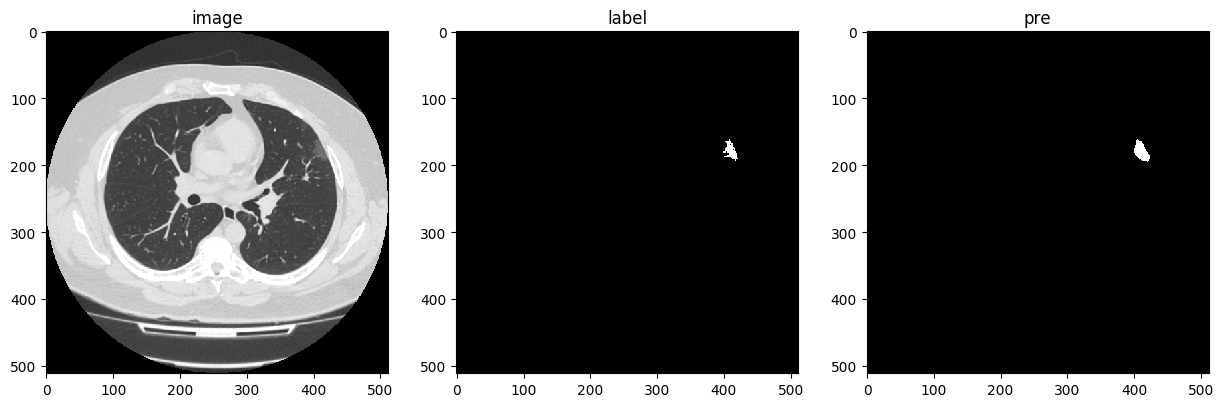

In [10]:
params = '/home/aistudio/BestModel/BiSeNet_model.pdparams'
model = BiSeNetV2(num_classes=2 )
img_path = '/home/aistudio/work/MosMedSegPNG/origin/study_0271_20.png'
lab_path = '/home/aistudio/work/MosMedSegPNG/mask/study_0271_20.png'

img = np.asarray(Image.open(img_path))
lab = np.asarray(Image.open(lab_path))
# 还原大小
pre = cv2.resize(nn_infer(model, img, params), (lab.shape[1], lab.shape[0]), cv2.INTER_NEAREST)
plt.figure(figsize=(15, 10))
plt.subplot(131);plt.imshow(img,'gray');plt.title('image')
plt.subplot(132);plt.imshow(lab,'gray');plt.title('label')
plt.subplot(133);plt.imshow(pre,'gray');plt.title('pre')
plt.show()

In [14]:
params = '/home/aistudio/BestModel/Unet_model.pdparams'
model = UNet(num_classes=2 )

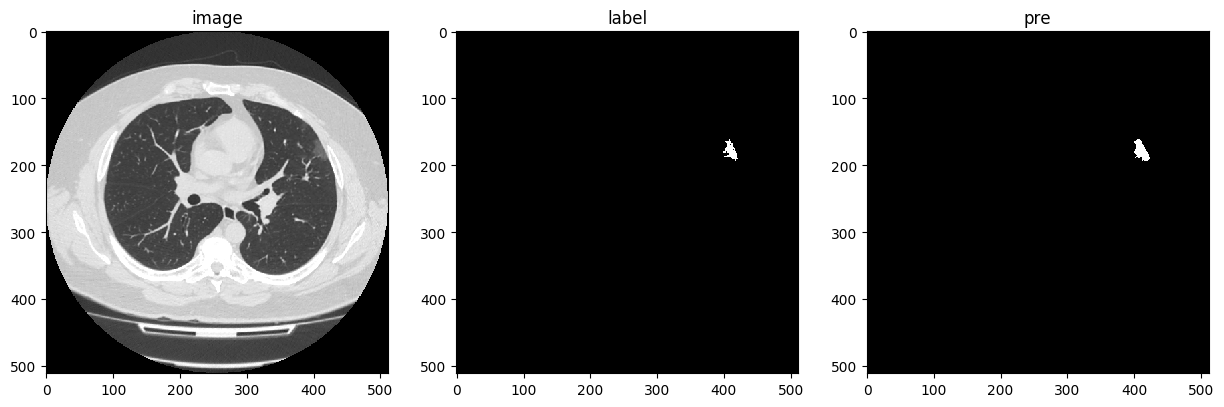

In [15]:

img_path = '/home/aistudio/work/MosMedSegPNG/origin/study_0271_20.png'
lab_path = '/home/aistudio/work/MosMedSegPNG/mask/study_0271_20.png'

img = np.asarray(Image.open(img_path))
lab = np.asarray(Image.open(lab_path))
# 还原大小
pre = cv2.resize(nn_infer(model, img, params), (lab.shape[1], lab.shape[0]), cv2.INTER_NEAREST)
plt.figure(figsize=(15, 10))
plt.subplot(131);plt.imshow(img,'gray');plt.title('image')
plt.subplot(132);plt.imshow(lab,'gray');plt.title('label')
plt.subplot(133);plt.imshow(pre,'gray');plt.title('pre')
plt.show()

# 对Nifit文件进行推理

In [16]:
import SimpleITK as sitk
from paddleseg.core import infer
def wwwc(sitkImage,ww=1500,wc=-550):
    #设置窗宽窗位
    min = int(wc - ww/2.0)
    max = int(wc + ww/2.0)
    intensityWindow = sitk.IntensityWindowingImageFilter()
    intensityWindow.SetWindowMaximum(max)
    intensityWindow.SetWindowMinimum(min)
    sitkImage = intensityWindow.Execute(sitkImage)
    return sitkImage

def readNii(path,isflipud=True):
    """读取和加载数据"""
    img = wwwc(sitk.ReadImage(path))
    data = sitk.GetArrayFromImage(img)
    #图像是上下翻转的，所有把他们翻转过来
    if isflipud:
        data = np.flip(data,1)
    return data

def nn_infer(model, im):
    # 预测结果
    transforms = T.Compose([
    T.Resize(target_size=(512, 512)),
    T.Normalize()
        ])
    img, _ = transforms(im)
    img = paddle.to_tensor(img[np.newaxis, :])
    pre = infer.inference(model, img)
    pred = paddle.argmax(pre, axis=1).numpy().reshape((512, 512))
    return pred.astype('uint8')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/SimpleITK/extra.py:183: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  _np_sitk = {np.dtype(np.character): sitkUInt8,


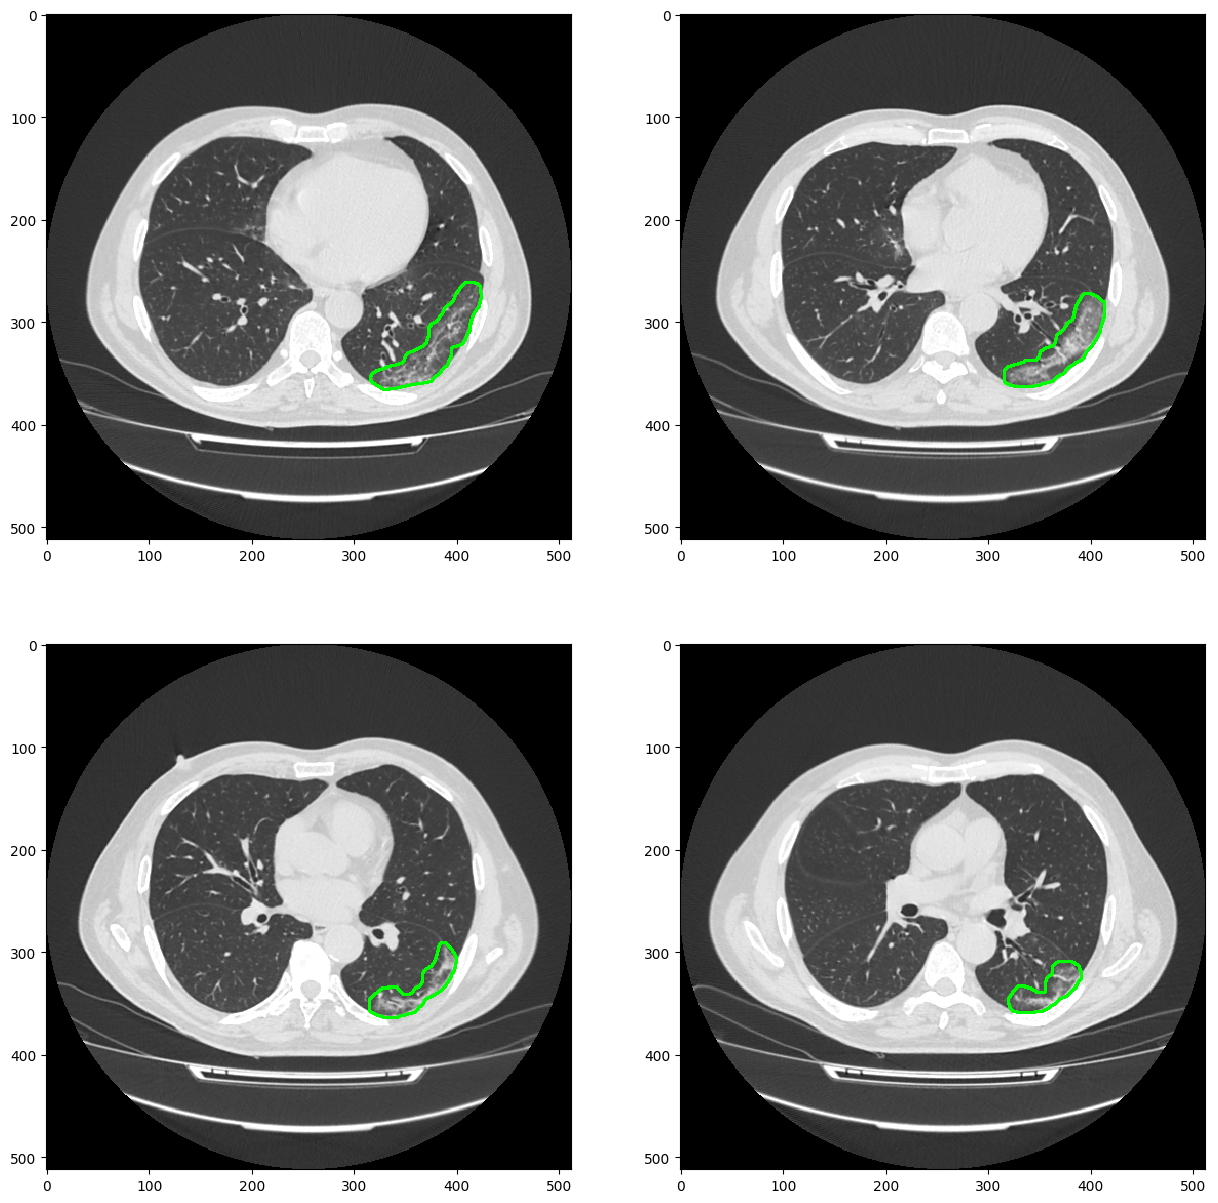

In [17]:
#原始医疗数据的文件路径，格式Nifit
origin_f_path = '/home/aistudio/study_0306.nii'
#通过SimpleITK读取，并设置窗宽窗位并缩放到0~255之间，并转换成numpy格式
origin_numpy = readNii(origin_f_path).astype(np.uint8)
d,h,w = origin_numpy.shape
#用来保存结果。
result = np.zeros((d,h,w,3)).astype(np.uint8)
mask_numpy = np.zeros_like(origin_numpy).astype(np.uint8)

model_path = '/home/aistudio/BestModel/BiSeNet_model.pdparams'
model = BiSeNetV2(num_classes=2 )
para_state_dict = paddle.load(model_path)
model.set_dict(para_state_dict)

for i in range(d):
    img = origin_numpy[i].copy()
    img = np.expand_dims(img, axis=2)
    img = np.concatenate((img, img, img), axis=-1).astype(np.uint8)
    pre = cv2.resize(nn_infer(model, origin_numpy[i]), (512,512), cv2.INTER_NEAREST)
    mask_numpy[i] = pre
    ret,thresh = cv2.threshold(pre,0,255,cv2.THRESH_BINARY)
    thresh = cv2.dilate(thresh, kernel=np.ones((5, 5), np.uint8), iterations=1)
    contours, hierarchy = cv2.findContours(thresh, 1, 2)
    # 画出轮廓
    img = cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    result[i] =  img

#把预测出来的mask保存成三维的Nifit格式。
mask_numpy = np.flip(mask_numpy, 1)
pre_sitkImage = sitk.GetImageFromArray(mask_numpy)
pre_sitkImage.CopyInformation(sitk.ReadImage(origin_f_path))
pre_sitkImage = sitk.Cast(pre_sitkImage, sitk.sitkUInt8)
save_path =origin_f_path.split('.')[0] + '_mask.nii'
sitk.WriteImage(pre_sitkImage, save_path)

plt.figure(figsize=(15, 15))
plt.subplot(221);plt.imshow(result[20])
plt.subplot(222);plt.imshow(result[22])
plt.subplot(223);plt.imshow(result[24])
plt.subplot(224);plt.imshow(result[26])
plt.show()